### Install Dependency

In [ ]:
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install scipy
%pip install statsmodels

### Imports

In [18]:
#Python 3.8.13
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import warnings
from colorama import Fore
warnings.filterwarnings("ignore")
register_matplotlib_converters()

### Retrive data from .csv file

In [150]:
#Read data
csv_file = 'CPIUS.csv'
df = pd.read_csv('DataSet\\'+csv_file)
df.dropna(inplace=True)
df.head()

,DATE,CPILFENS
0,1957-01-01,28.5
1,1957-02-01,28.5
2,1957-03-01,28.7
3,1957-04-01,28.8
4,1957-05-01,28.8


### Require Dataframe with format (datetime , Time Series data) only

In [ ]:
#Data cleaning
# df['Date'] = df['Year']
# for index in df.index:
#     if (df['Quarter'][index] == 'Q1'):
#         df['Date'][index] = str(df['Year'][index]) + '-03-01'
#     elif (df['Quarter'][index] == 'Q2'):
#         df['Date'][index] = str(df['Year'][index]) + '-06-01'
#     elif (df['Quarter'][index] == 'Q3'):
#         df['Date'][index] = str(df['Year'][index]) + '-09-01'
#     elif (df['Quarter'][index] == 'Q4'):
#         df['Date'][index] = str(df['Year'][index]) + '-12-01'

# convert floating point to int then to str
df['Date'] = df['year'].astype(str) + '-' + (df['month'].astype(int)).astype(str) + '-01'
df.head()

### Data Cleaning

In [151]:
#Data cleaning
df_clean = df.loc[:,['DATE','CPILFENS']]
df_clean.rename(columns={'DATE':'date','CPILFENS':'cpi'},inplace=True)
df_clean['date'] = pd.to_datetime(df_clean.date)
df.dropna(inplace=True)
df_clean.tail()

,date,cpi
785,2022-06-01,294.680
786,2022-07-01,295.646
787,2022-08-01,297.178
788,2022-09-01,298.442
789,2022-10-01,299.315


In [152]:
#Subseting data, Leave some data for forcecasting
df_clean.set_index('date',inplace=True)
start_year, end_year = 1957, 2022
start_date = pd.to_datetime(str(start_year) + '-01-01')
end_date = pd.to_datetime(str(end_year) +'-05-01')
df_clean = df_clean[start_date:end_date]
df.dropna(inplace=True)
df_train = df_clean.copy()
df_clean.tail()

,cpi
date,
2022-01-01,285.996
2022-02-01,288.059
2022-03-01,289.305
2022-04-01,290.846
2022-05-01,292.506


### Useful function for printing out test output

In [168]:
#Print Graph
def plotGraph(dataframe, column, plottitle, plotylabel, startyear, endyear):
    plt.figure(figsize=(10,4))
    plt.plot(dataframe[column])
    plt.title(plottitle, fontsize=20)
    plt.ylabel(plotylabel, fontsize=16) 
    for year in range(startyear,endyear):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

#Augmented Dickey-Fuller (ADF) Test:
#Null hypothesis: non-stationary - if p-value < 5% reject null hypothesis
def ADFtest(dataframe, column):
    adfuller_result = adfuller(dataframe[column].values, autolag='AIC')
    print(f'ADF statistic: {adfuller_result[0]}')
    print(f'p-value      : {adfuller_result[1]}')
    for key, value in adfuller_result[4].items():
        print('Critical values:')
        print(f'  {key},  {value}')
    if (adfuller_result[1] <= 0.05):
        print(Fore.GREEN + f'It is stationary (p-value: {adfuller_result[1]})')
    else:
        print(Fore.LIGHTRED_EX + f'It is non-stationary (p-value: {adfuller_result[1]})')

#The additive model is useful when the seasonal variation is relatively constant over time.
#The multiplicative model is useful when the seasonal variation increases over time.
def seasonDecomposer(dataframe, column, models='additive', periods=1):
    plt.rcParams.update({'figure.figsize':(10,10)})
    seasonal_decompose(dataframe[column], model=models, period=periods).plot().suptitle(f'\n{models} decompose', fontsize=12)

#Combine all funtions
def plotAll(dataframe, column, plottitle, plotylabel, startyear, endyear, models='additive', periods=1, lag=30):
    ADFtest(dataframe, column)
    plotGraph(dataframe, column, plottitle, plotylabel, startyear, endyear)
    # “ywm” : Yule-Walker without adjustment. Default.
    # “yw”  : Yule-Walker with sample-size adjustment in denominator for acovf. Default.
    #alpha  : 0.05 = 95% confidence interval
    plt.rcParams.update({'figure.figsize':(10,4)})
    plot_acf(dataframe[column],  alpha=.05, lags=lag)
    plot_pacf(dataframe[column],  alpha=.05, method='ywm',lags=lag)   
    seasonDecomposer(dataframe, column, models, periods)

#Check all stationarity after log and differencing
def allStationarity(dataframe,column):
    dataframe['after_log'] = np.log(dataframe[column])
    dataframe['difference_1'] = dataframe[column] - dataframe[column].shift(1)
    dataframe['difference_2'] = dataframe[column] - 2*dataframe[column].shift(1) + dataframe[column].shift(2)
    dataframe['log_difference_1'] = dataframe['after_log'] - dataframe['after_log'].shift(1)
    dataframe['log_difference_2'] = dataframe['after_log'] - 2*dataframe['after_log'].shift(1) + dataframe['after_log'].shift(2)
    dataframe.dropna(inplace=True)
    for data in [column,'after_log','difference_1','difference_2','log_difference_1','log_difference_2']:
        adfuller_result = adfuller(dataframe[data].values, autolag='AIC')
        if (adfuller_result[1] <= 0.05):
            print(Fore.GREEN + f'{data} : stationary (p-value: {adfuller_result[1]})')
        else:
            print(Fore.LIGHTRED_EX + f'{data} : non-stationary (p-value: {adfuller_result[1]})')

#Ljung-Box test for serial correlation of standardized residuals
def lgBoxResult(result):
    test_stat = result[0][0]
    p_value = result[0][1]
    for i in range(len(test_stat)):
        print(Fore.RESET + f'At Lag: {i}, Test statistic: {test_stat[i]}, p-value:{p_value[i]}')
        if (p_value[i] <= 0.05):
            print(Fore.LIGHTRED_EX + f'p-value =< 0.05, Null hypothesis is rejected, there is serial correlation.')
        else:
            print(Fore.GREEN + f'p-value > 0.05, Null hypothesis is not rejected, there is no serial correlation.')
        print(Fore.RESET + '------------------------------------------------------------------------------------------')

#Shapiro-Wilk normality test
def shapiro_test(np_array):
    '''
    https://github.com/scipy/scipy/blob/v1.9.3/scipy/stats/_morestats.py#L1727-L1802
    The chance of rejecting the null hypothesis when it is true is close to 5%
    regardless of sample size.
    '''
    shapiro_result = shapiro(np_array)
    print('-------------------------------Shapiro-Wilk normality test Result------------------------------')
    print(f'Test statistic: {shapiro_result.statistic}')
    print(f'p-value       : {shapiro_result.pvalue}')
    if (shapiro_result.pvalue <= 0.05):
        print(Fore.LIGHTRED_EX + f'p-value <= 0.05, Null hypothesis is rejected, data was NOT drawn from a normal distribution.')
    else:
        print(Fore.GREEN + f'p-value > 0.05, Null hypothesis is not rejected, data was drawn from a normal distribution.')
    print(Fore.RESET + '-----------------------------------------------------------------------------------------------')

def plotStdResid(std_resid_array):
    plt.figure(figsize=(10,4))
    plt.plot(std_resid_array)
    plt.title('Standardized Residuals Sequence', fontsize=20)
    plt.ylabel('Standardized Residuals', fontsize=16) 
    

### Original Time Series data plot with stationarity, seasonality check

ADF statistic: 2.2632534688576627
p-value      : 0.9989306411923617
Critical values:
  1%,  -3.4389722010249386
Critical values:
  5%,  -2.8653454308425705
Critical values:
  10%,  -2.5687964010457227
It is non-stationary (p-value: 0.9989306411923617)


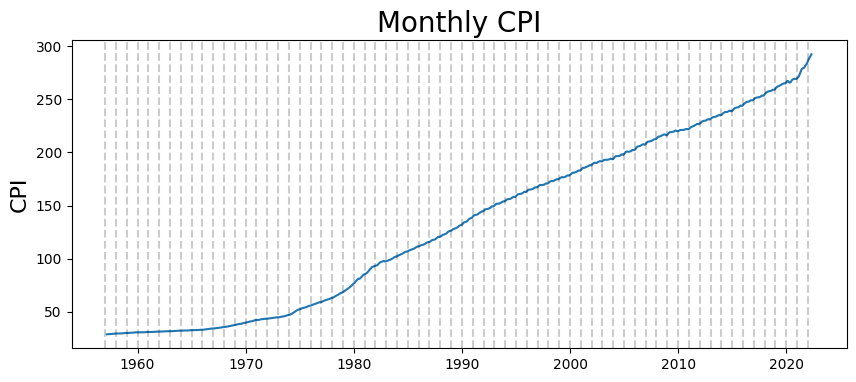

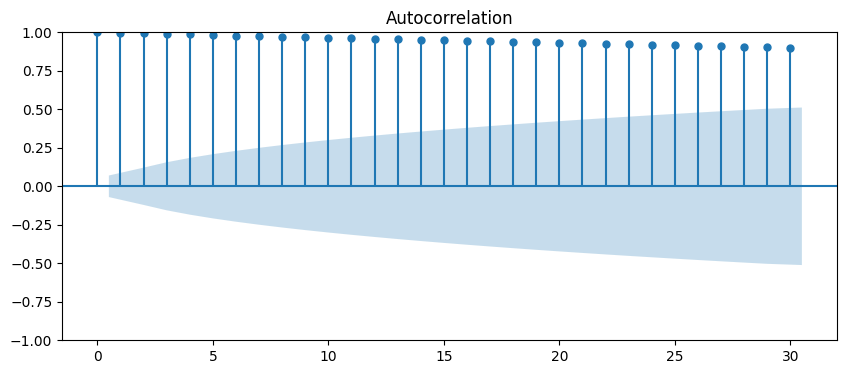

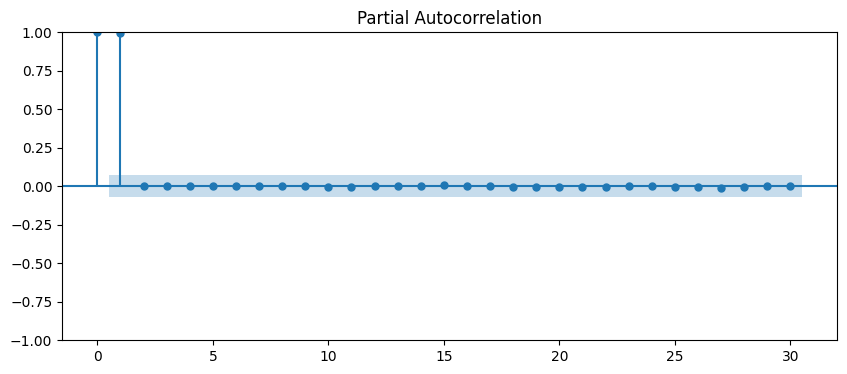

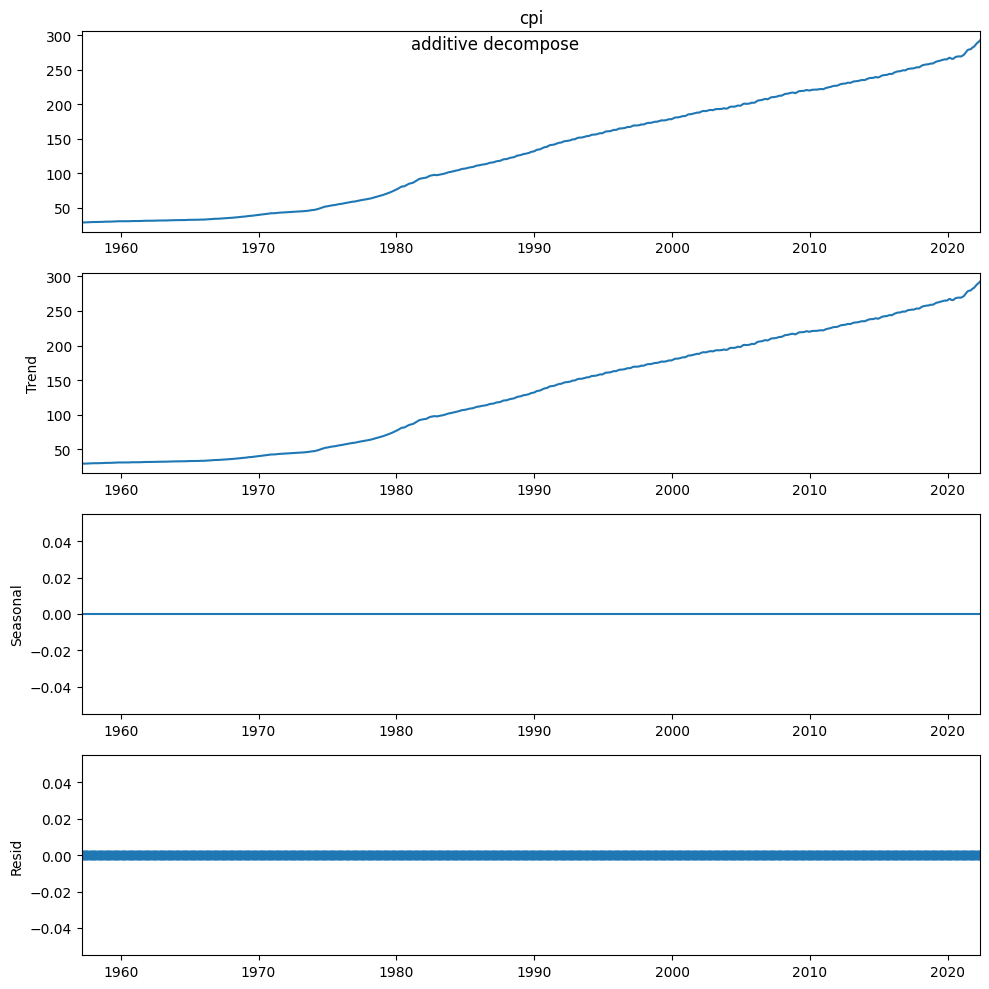

In [180]:
plotAll(df_clean, 'cpi', 'Monthly CPI', 'CPI', start_year, end_year+1, models='additive', periods=1)

### Calculating all the possible Time Series data transformation

Please run this before running the below graph plotting

In [ ]:
#All stationarity result after log and differencing
# ['after_log','difference_1','difference_2','log_difference_1','log_difference_2']
allStationarity(df_clean,'cpi')
df_log = df_clean[['after_log']]

### Graph ploting with stationartiy, seasonality check

ADF statistic: -3.0663625758888307
p-value      : 0.029144745441184283
Critical values:
  1%,  -3.4389722010249386
Critical values:
  5%,  -2.8653454308425705
Critical values:
  10%,  -2.5687964010457227
It is stationary (p-value: 0.029144745441184283)


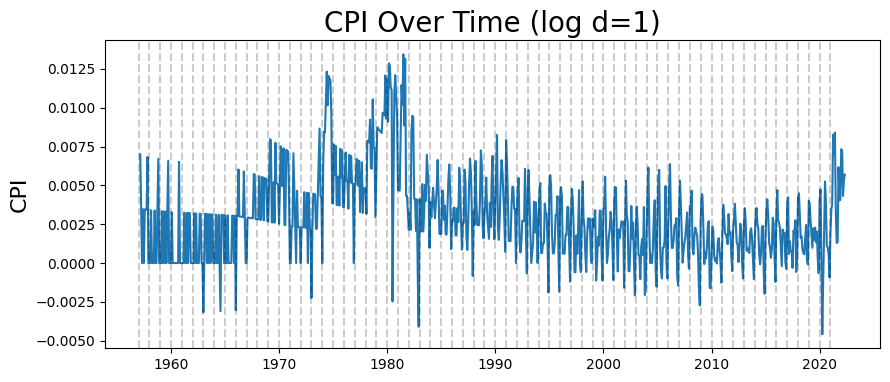

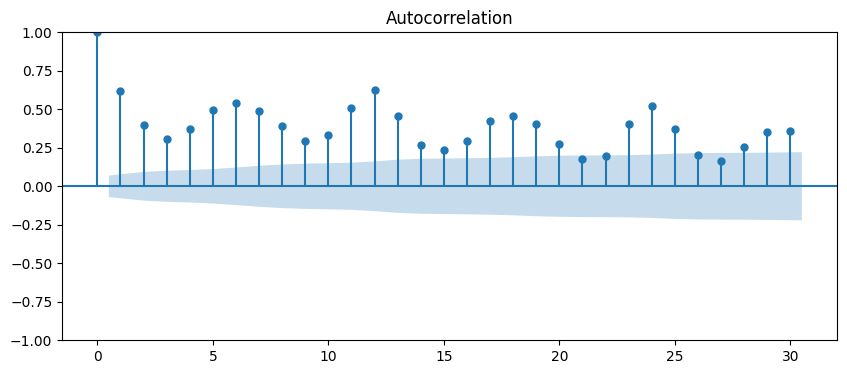

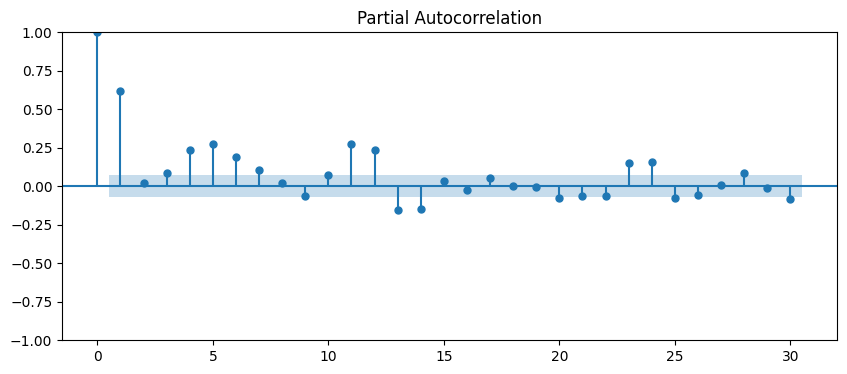

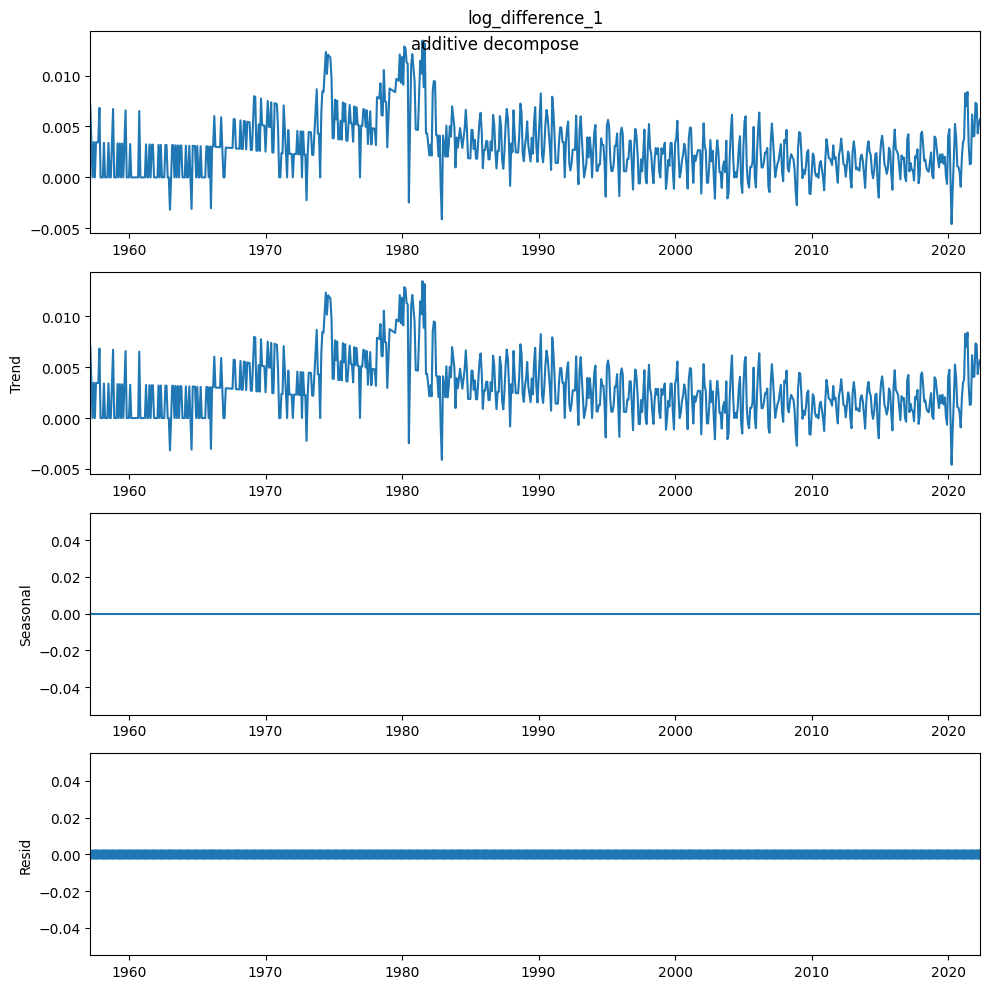

In [182]:
#Log Transformation
# plotAll(dataframe, column, plottitle, plotylabel, startyear, endyear, models='additive', periods=1)
plotAll(df_clean, 'log_difference_1', 'CPI Over Time (log d=1)', 'CPI', start_year, end_year, models='additive', periods=1)

In [ ]:
#Second order differencing
plotAll(df_clean, 'log_difference_2', 'CPI Over Time (log, d=2)', 'CPI', start_year, end_year+1, models='additive', periods=1, lag=100)

### Model fitting, please fit a model according to the ACF and PACF plot

In [ ]:
#https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.html#statsmodels-tsa-arima-model-arimaresults
#Use df_log for logged data, use df_train for original data
model = ARIMA(df_log, order=(2,1,3), seasonal_order=(0, 0, 0, 0))
#Using Maximum likelihood estimation
model_fit = model.fit(method='innovations_mle')
print(model_fit.summary())

### Residual Analysis
#### Ljung-Box test for model adequacy

In [ ]:
'''
https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima.model.ARIMAResults.test_serial_correlation.html
Ljung-Box test for serial correlation of standardized residuals (check the adequacy)
Null hypothesis is no serial correlation.
df_adjust: when true df = k-p-q
lags: default maxlag is min(10, number of observation//5), (lags is K)
'''
result = model_fit.test_serial_correlation(method='ljungbox',df_adjust=True, lags=10)
lgBoxResult(result)

#### Standardized Residual: Sequence, Histogram, Q-Q plot, Correlogram, ACF, PACF

In [ ]:
'''Test for normality of standardized residuals'''

#extract residuals sequence and calculate standardized residuals sequence
resid = model_fit.resid[2:]
std_resid = resid / resid.std()
plotStdResid(std_resid)

#The Jarque-Bera test of normality. (Not used)
model_fit.test_normality(method='jarquebera')

#Shapiro-Wilk normality test
#Null hypothesis: data was drawn from a normal distribution
shapiro_test(std_resid)

#Standardized residual sequence, Histogram, Q-Q plot, correlogram
print(model_fit.plot_diagnostics(figsize=(10,10)))

#ACF and PACF of the residuals
plt.rcParams.update({'figure.figsize':(10,4)})
print(plot_acf(std_resid,  alpha=.05, lags=30, title='Standardized residuals Autocorrelation'))
print(plot_pacf(std_resid,  alpha=.05, method='ywm',lags=30, title='Standardized residuals Partial Autocorrelation'))

In [ ]:
'''
Overparameterized method to check the adequacy
'''
